# Experimentation with DOS Event

2016-7-28 from 11:00 to 14:00, during this time period, the following events occured

| Time  |   |
|-----------------------|
|12:04:00 PM|12:56:00 PM|
|12:05:00 PM|12:57:00 PM|
|12:06:00 PM|01:07:00 PM|
|12:07:00 PM|01:08:00 PM|
|12:16:00 PM|01:09:00 PM|
|12:17:00 PM|01:10:00 PM|
|12:18:00 PM|01:13:00 PM|
|12:19:00 PM|01:14:00 PM|
|12:54:00 PM|01:15:00 PM|
|12:55:00 PM|01:16:00 PM|


So we investigate the following time period: 11:00 to 14:00

In [55]:
%matplotlib inline
# Preamble
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import datetime
from dateutil.parser import parse
import collections
import math
import time
import os
import subprocess

import graphviz as gv
import hashlib
import pickle

# make plots prettier
plt.style.use('default')

# Convenience methods
from EWMA_CUSUM import *

In [4]:
# Experiment Variables
width = 5 * 60 # 5 minutes
features = ['te', 'td', 'sa', 'da', 'sp', 'dp', 'pr', 'flg', 'fwd', 'stos', 'pkt', 'byt']
filename = "data/2016-07-28/2016-07-28_100.csv"
anomalyFilename = 'data/2016-07-28/attacks_ts.csv'
startDate = parse("2016-07-28 11:00:00")
endDate = parse("2016-07-28 14:00:00")
minSup = 0.1

attackers = ["42.219.150.246", "42.219.150.247", "42.219.150.243", "42.219.150.242", "42.219.150.241"]

V11_V15 = ["42.219.156.30", "42.219.156.31", "42.219.156.29", "42.219.156.28", "42.219.156.27"] 
V21_V25 = ["42.219.158.16", "42.219.158.17", "42.219.158.18", "42.219.158.19", "42.219.158.21"] 
V31_V35 = ["42.219.152.20", "42.219.152.21", "42.219.152.22", "42.219.152.23", "42.219.152.18"]
V41_V45 = ["42.219.154.69", "42.219.154.68", "42.219.154.70", "42.219.154.71", "42.219.154.66"]

victims = V11_V15 + V21_V25 + V31_V35 + V41_V45

In [27]:
# Filter by time window from 11:00 to 14:00
# df = pd.read_csv(filename)
# df_filtered = df[df.apply(lambda x: startDate <= parse(x['te']) <= endDate , axis=1)]
# export as csv
# df_filtered.to_csv("data/2016-07-28_100_1100_1400.csv")

df = pd.read_csv("data/2016-07-28_100_1100_1400.csv")
df_anom = readAnomalyFile(anomalyFilename, width)

In [8]:
def timeBin(df, width):
    col = 'te'
    df['timebin'] = df.apply (lambda row: createTimebin(row, width, col),axis=1)
    return df

def timeBinToDate(x, width):
    return datetime.datetime.fromtimestamp(x * width)

df_binned = timeBin(df, width)

In [9]:
df_groups = [(timeBinToDate(i, width), x) for i, x in df_binned.groupby('timebin')]

In [10]:
# SAM Stuff
def translatetoSAMinput(df, features = ['sa', 'da', 'sp', 'sp']):
    cols = list(df.columns)
    lines = []
    for index, row in df.iterrows():
        line = " ".join(["{0}:{1}".format(f, row[f]) for f in features])
        lines.append(line)
    return "\n".join(lines)

def invokeMaximalSAM(inputStr, minSup=10):
    inFileName = 'temp_binning.in'
    outFileName = 'temp_binning.out'
    
    inFile = open(inFileName, 'w+')
    inFile.write(inputStr)
    inFile.close()
    
    # maximal FIM (-m)
    subprocess.call(["./sam", '-m', '-m2', '-s' + str(minSup), inFileName, outFileName])
    lines = open(outFileName).readlines()
    
    result = {}
    for line in lines:
        *itemset, supp = line.split()
        supp = float(supp[1:-1])
        result[tuple(sorted(itemset))] = supp
    
    os.remove(inFileName)
    os.remove(outFileName)
    
    return result

def FIM(df, minSup):
    samInput = translatetoSAMinput(df)
    samOutput = invokeMaximalSAM(samInput, minSup)
    return samOutput

In [11]:
def graphFromSAM(samOutput):
    g1 = gv.Graph(format='svg', engine='sfdp')

    def getLabel(id):
        # guaranteed that id is in idToLabel
        return idToLabel[id]

    def hashString(s):
        hash_object = hashlib.sha1(str.encode(s))
        hex_dig = hash_object.hexdigest()
        return hex_dig[:8]
    
    getId = hashString

    for itemSet in samOutput.keys():
        sup = samOutput[itemSet]
        itemSetStr = hashString(" ".join(list(itemSet)))
        supId = hashString(itemSetStr)
        g1.node(supId, itemSetStr, shape='box')

        # add node
        for attr in itemSet:
            attrId = getId(attr)
            g1.node(attrId, attr)
            g1.edge(supId, attrId, weight = str(sup))
            
            # set color if victim or attacker
            if attr.startswith('da') or attr.startswith('sa'):
                ip = attr.split(':')[1]
                if ip in attackers:
                    g1.node(attrId, color = 'red', style = 'filled')
                elif ip in victims:
                    g1.node(attrId, color = 'purple', style = 'filled')

    return g1

## Attack at 12:30

As evident in the hypergraph, there are many connected components that are caused by the attacks. 

These connected components are likely to lead to large edit distances that can be used to detect for anomalies.

The red nodes are attacker IP addresses and purple nodes are victim IP addresses.

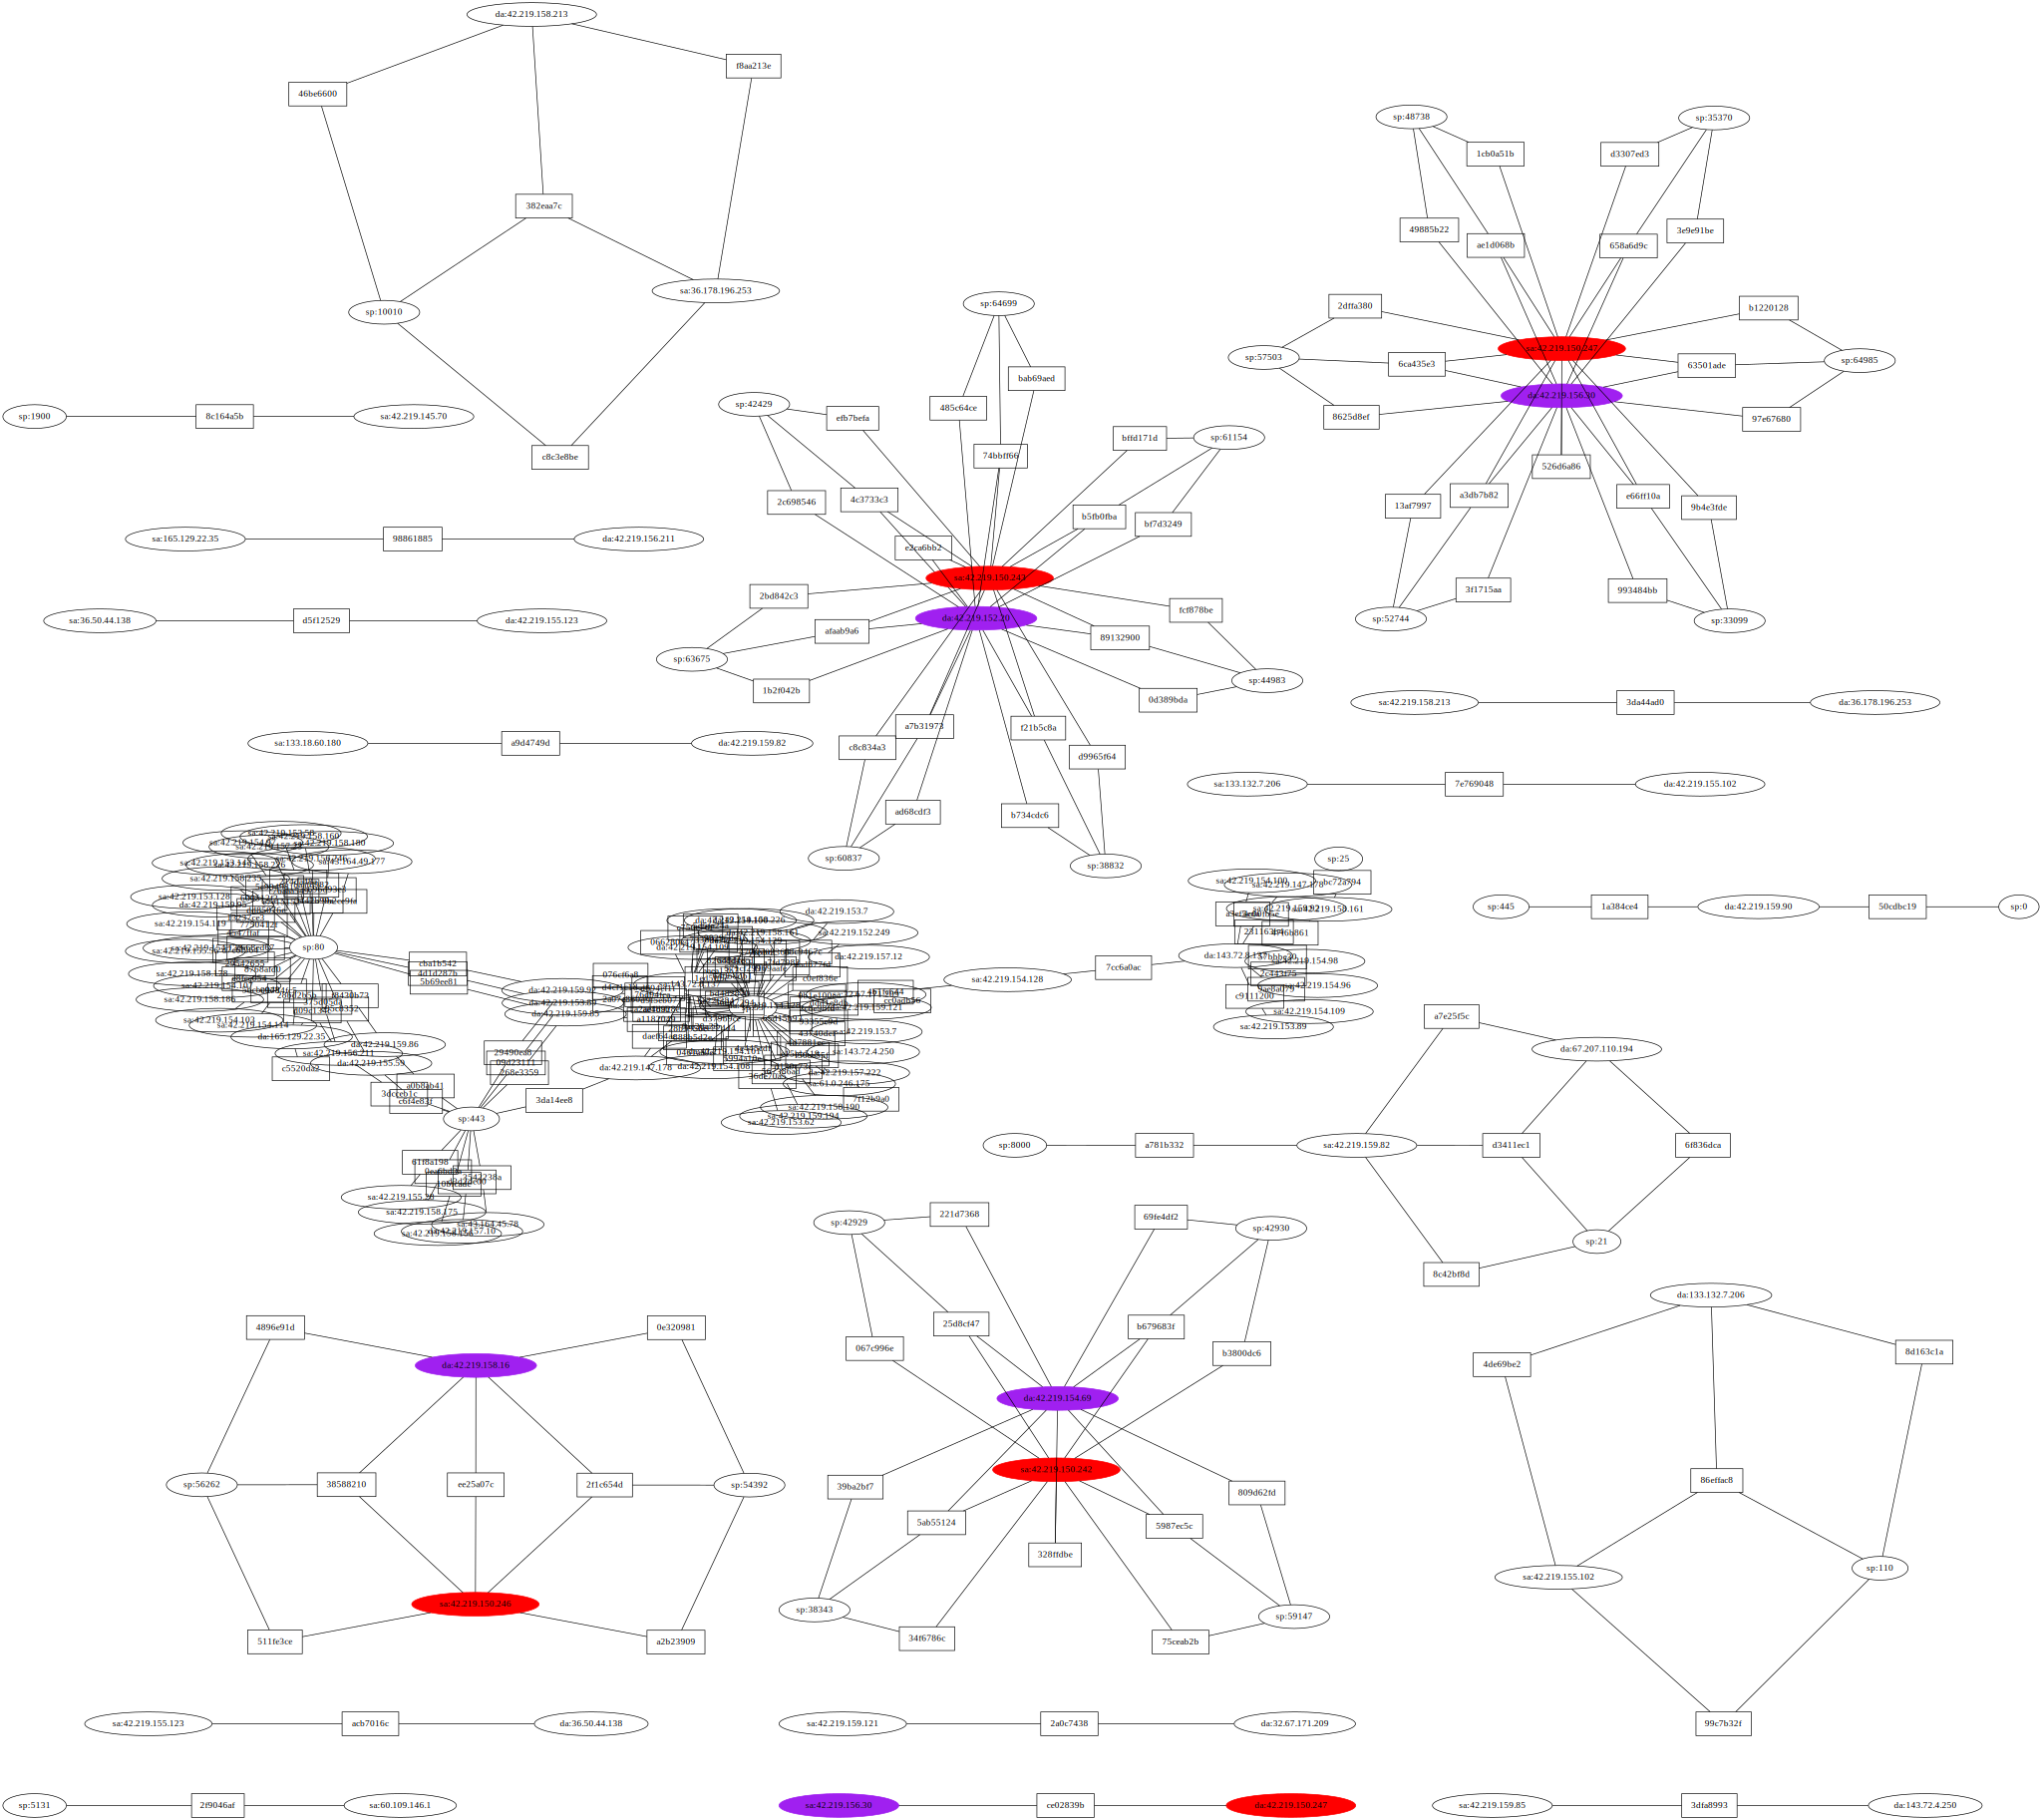

In [12]:
%matplotlib inline
# 18 -> 12:30 (largest peak)
df_temp = df_groups[18][1]
samOutput = FIM(df_temp, minSup)
g1 = graphFromSAM(samOutput)
g1

In [11]:
# Create graphs for all timebins
# WARNING: slow operation
timeLabelAndGraph = [(l, graphFromSAM(FIM(df, minSup))) for l, df in df_groups]

# export all graphs as an image
for time, graph in timeLabelAndGraph:
    graph.render('2016-07-28/images/'+str(time))

In [13]:
def graphFromFIM(samOutput):
    nodes = set()
    itemsets = set()
    edges = {} # (node, itemset) -> support
    
    def hashString(s):
        hash_object = hashlib.sha1(s.encode())
        hex_dig = hash_object.hexdigest()
        return hex_dig

    
    for itemSet in samOutput.keys():
        sup = samOutput[itemSet]
        itemSetStr = hashString(" ".join(list(itemSet)))
        itemsets.add(itemSetStr)

        # add nodes
        for attr in itemSet:
            nodes.add(attr)
            edges[(attr, itemSetStr)] = sup
            
    return (nodes, itemsets, edges)

'''
Edit distance = number of edits required
'''
def editDistance(graph1, graph2):
    dist = 0
    
    g1nodes, g1items, g1edges = graph1
    g2nodes, g2items, g2edges = graph2
    
    dist += len(g1nodes.symmetric_difference(g2nodes))
    dist += len(g1items.symmetric_difference(g2items))
    
    edges1 = set(g1edges.keys())
    edges2 = set(g2edges.keys())
    dist += len(edges1.symmetric_difference(edges2))
    
    return dist
    
'''
Compute edit distance by sum of difference in support (multiplied by cardinality of itemset)
'''
def editDistanceWeighted(graph1, graph2):
    dist = 0
    _nodes, _items, edgeWeights1 = graph1
    _nodes, _items, edgeWeights2 = graph2
    
    for e in edgeWeights1.keys():
        if e not in edgeWeights2:
            dist += minSup + edgeWeights1[e]
        else:
            dist += abs(edgeWeights1[e] - edgeWeights2[e])
    
    for e in edgeWeights2.keys():
        if e not in edgeWeights1:
            dist += minSup + edgeWeights2[e]
        else:
            dist += abs(edgeWeights1[e] - edgeWeights2[e])
    return dist

Now compute the edit distances for adjacent time bins, will probably lead to a lot of noise

In [14]:
# run SAM on all groups (WARNING: slow operation)
FIMGroups = [FIM(df, minSup) for _, df in df_groups]

In [15]:
# save results in a pickle
FIMGroupLabels = [str(label) for label, df in df_groups]
d = {label : fim for label, fim in zip(FIMGroupLabels, FIMGroups)}
pickle.dump(d, open('2016-7-28-FIM.p', 'wb'))

In [16]:
def editDistanceTimeSeries(FIMGroups, editDistance):
    index = [i for i, g in df_groups]
    columns = ['distance']
    data = np.array([0 for i in range(len(df_groups))], dtype = 'f')
    
    for currIdx in range(1,len(index)-1):
        prevIdx = currIdx - 1

        currSamOutput = FIMGroups[currIdx]
        prevSamOutput = FIMGroups[prevIdx]    

        gCurr = graphFromFIM(currSamOutput)
        gPrev = graphFromFIM(prevSamOutput)    

        dist = editDistance(gCurr, gPrev)
        data[currIdx] = dist
    
    df_editDistance = pd.DataFrame(data, index = index, columns = columns)
    return df_editDistance

index = [i for i, g in df_groups]
columns = ['distance']
data = np.array([0 for i in range(len(df_groups))], dtype = 'f')

In [17]:
df_editDistance = editDistanceTimeSeries(FIMGroups, editDistance)
df_editDistanceWeighted = editDistanceTimeSeries(FIMGroups, editDistanceWeighted)

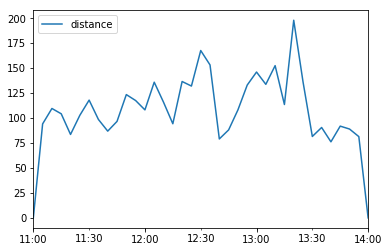

In [18]:
%matplotlib inline
df_editDistanceWeighted.plot()

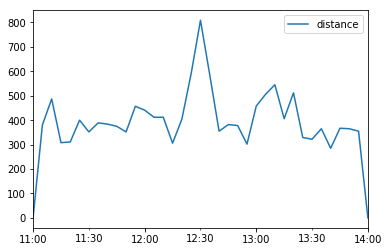

In [19]:
%matplotlib inline
df_editDistance.plot()

A spike can be observed on both graphs. Run EWMA and CUSUM on both graphs

# EWMA and CUSUM

From adjacent graph edit distance alone, only the peak at 12:30 stands out.

In [104]:
def ewma(df, colName, sp = 3):
    temp = pd_ewma(df, span = sp).mean()
    df[colName + '_bar'] = temp[colName]
    return df

def forecastError(df, colName):
    df['e_t'] = 0
    for i in range(1, len(df)):
        currIdx = df.index[i]
        prevIdx = df.index[i-1]
        df.loc[currIdx, 'e_t'] = df.loc[currIdx, colName] \
            - df.loc[prevIdx, colName + '_bar']
    return df

def upperThreshold(df, colName, c_thres = 1, M_min = 1, c_cusum = 1):
    df['T_upper'] = 0
    df['S_t'] = 0
    df['T_cusum']=  0
    for i in range(2, len(df)):
        sigma = df['e_t'][:i].std()
        currIdx = df.index[i]
        prevIdx = df.index[i-1]
        T_val = df.loc[prevIdx, colName + '_bar'] + max(c_thres * sigma, M_min)

        S_t_min_1 = df.loc[prevIdx, 'S_t']
        x_t = df.loc[currIdx, colName]
        S_t = max(S_t_min_1 + x_t - T_val, 0)

        T_t = c_cusum * sigma

        df.loc[currIdx, 'T_upper'] = T_val
        df.loc[currIdx, 'S_t'] = S_t
        df.loc[currIdx, 'T_cusum'] = T_t

    return df

def cusum(df, colName, c_thres = 1, M_min = 1, c_cusum = 1):
    df1 = forecastError(df, colName)
    df2 = upperThreshold(df1, colName, c_thres, M_min, 1)
    return df2


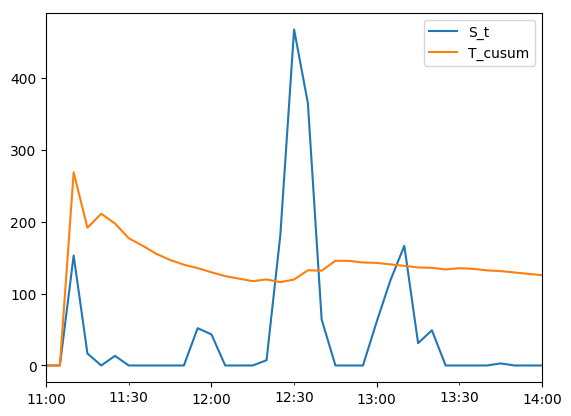

In [109]:
df_ewma = ewma(df_editDistance, 'distance')
df_ewma_cusum = cusum(df_ewma, 'distance',
                      c_thres = 0.30, M_min = 0.5, c_cusum = 0.60)
df_ewma_cusum[['S_t', 'T_cusum']].plot()

Two events, 12:30 (port scan attack), 13:20: 

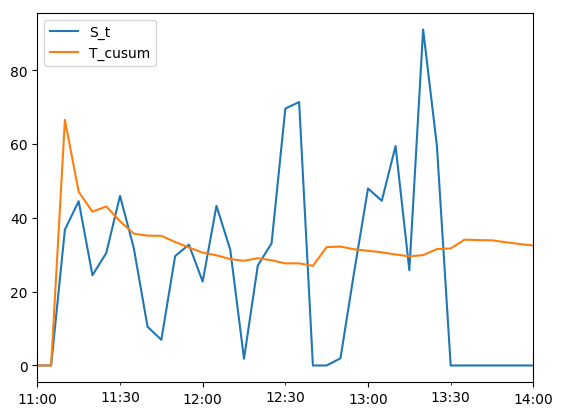

In [114]:
dfWeighted_ewma = ewma(df_editDistanceWeighted, 'distance')
dfWeighted_ewma_cusum = cusum(dfWeighted_ewma, 'distance', 
                              c_thres = 0.15, M_min = 0.5, c_cusum = 0.10)
#                               c_thres = 0.15, M_min = 0.5, c_cusum = 0.60)
dfWeighted_ewma_cusum[['S_t', 'T_cusum']].plot()

In [38]:
# extract interesting events during the time window
start_time = pd.to_datetime("2016-07-28 11:00:00")
end_time = pd.to_datetime("2016-07-28 14:00:00")

df_anom_exp = df_anom[(df_anom.index > start_time) & df_anom.index < end_time]
df_anom_exp.head()

,counter(mins),Dos,scan44,scan11,nerisbotnet,blacklist,anomaly-udpscan,anomaly-sshscan,anomaly-spam
2016-07-28 11:05:00,1291,0,0,0,0,1,0,0,1
2016-07-28 11:10:00,1296,0,0,0,0,1,0,0,1
2016-07-28 11:15:00,1301,0,0,0,0,1,0,0,1
2016-07-28 11:20:00,1306,0,0,0,0,1,0,0,1
2016-07-28 11:25:00,1311,0,0,0,0,1,0,0,0


In [39]:
# attacks = ["Dos", "scan44","scan11","nerisbotnet","anomaly-udpscan", "anomaly-sshscan", "anomaly-spam"]
# restric to the 4 attacks that occurred
attacks = ["Dos", "scan44","scan11", "anomaly-spam"]

df_anom_exp = df_anom_exp[attacks]
df_anom_exp = df_anom_exp[df_anom_exp.apply(lambda r: sum(r[t] for t in attacks) > 0, axis = 1)]
df_anom_exp

,Dos,scan44,scan11,anomaly-spam
2016-07-28 11:05:00,0,0,0,1
2016-07-28 11:10:00,0,0,0,1
2016-07-28 11:15:00,0,0,0,1
2016-07-28 11:20:00,0,0,0,1
2016-07-28 12:00:00,1,0,0,0
2016-07-28 12:05:00,1,0,0,0
2016-07-28 12:10:00,0,0,0,1
2016-07-28 12:15:00,1,0,0,0
2016-07-28 12:25:00,0,1,0,1
2016-07-28 12:30:00,0,1,0,0


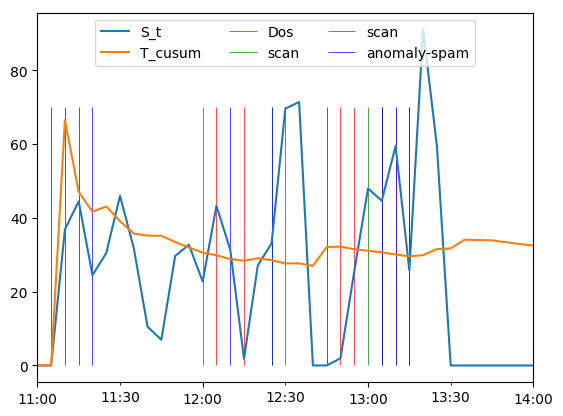

In [115]:
def addLines(df, feature,label,  d = 0, col = 'r'):
    df = df[df[feature] > 0]
    ax.vlines(df.index, 0, 70, colors=col, label=label, lw=0.5)
#     for idx in df.index:
#         ax.axvline(idx+ pd.Timedelta(minutes=d), label = label, color=col,lw=1)

plt.figure()
ax = dfWeighted_ewma_cusum[['S_t', 'T_cusum']].plot()
addLines(df_anom_exp, 'Dos', 'Dos', col = 'r')
addLines(df_anom_exp, 'scan44', 'scan', d=1, col = 'g')
addLines(df_anom_exp, 'scan11', 'scan', d=1, col = 'g')
addLines(df_anom_exp, 'anomaly-spam', 'anomaly-spam', d=2, col = 'b')
ax.legend(loc='upper center', ncol = 3)

In [116]:
fig = ax.get_figure()
fig.savefig('foo.png', bbox_inches='tight')

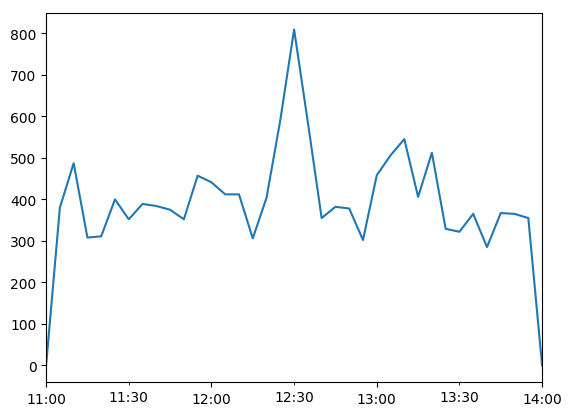

In [123]:
ax = df_editDistance['distance'].plot()

In [126]:
def addLines(df, feature,label,  d = 0, col = 'r'):
    df = df[df[feature] > 0]
    ax.vlines(df.index, 0, 70, colors=col, label=label, lw=0.5)
#     for idx in df.index:
#         ax.axvline(idx+ pd.Timedelta(minutes=d), label = label, color=col,lw=1)

plt.figure()
addLines(df_anom_exp, 'Dos', 'Dos', col = 'r')
addLines(df_anom_exp, 'scan44', 'scan', d=1, col = 'g')
addLines(df_anom_exp, 'scan11', 'scan', d=1, col = 'g')
addLines(df_anom_exp, 'anomaly-spam', 'anomaly-spam', d=2, col = 'b')
ax.legend(loc='upper center', ncol = 3)

# Run FIM with CUSUM for whole day

Now that we have established that a weighted edge edit distance is more sensitive to changes in the network, we ran FIM/CUSUM on the whole of 28/7/2016 (00:00 to 15:45)

In [52]:
df_day =  pd.read_csv(filename)
df_day_binned = timeBin(df_day, width)
df_day_groups = [(timeBinToDate(i, width), x) for i, x in df_day_binned.groupby('timebin')]

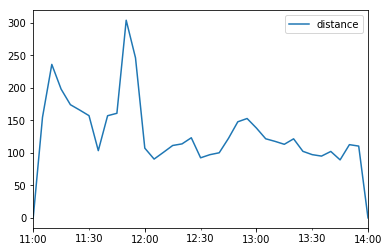

In [60]:
DayFIMGroups = [FIM(df, minSup) for _, df in df_day_groups]
df_day_editDistance = editDistanceTimeSeries(DayFIMGroups, editDistanceWeighted)
df_day_editDistance.plot()

df_day_ewma = ewma(df_day_editDistance, 'distance')
df_day_ewma_cusum = cusum(df_day_ewma, 'distance',
                      c_thres = 0.30, M_min = 0.5, c_cusum = 0.60)
df_day_ewma_cusum[['S_t', 'T_cusum']].plot()

In [65]:
def filterAnomalies(df):
    return df[df.apply(lambda x: x['S_t'] > x['T_cusum'], axis=1)]

reportedEvents = filterAnomalies(df_day_ewma_cusum)
reportedEvents

,distance,distance_bar,e_t,T_upper,S_t,T_cusum
2016-07-28 11:15:00,198.165192,189.302795,18.990849,204.309277,93.967648,83.783114
2016-07-28 11:50:00,304.091797,228.770989,150.715244,173.810693,130.281104,68.113800
2016-07-28 11:55:00,246.279572,237.527418,17.508583,251.310186,125.250489,75.130659


In [70]:
def eventMatching(df_reported, df_ground):
    events = ["Dos", "scan44", "scan11", "nerisbotnet", "blacklist", "anomaly-udpscan", "anomaly-sshscan", "anomaly-spam"]
    df_reported['Actual Event'] = ""
    for idx in df_reported.index:
        if idx in df_ground.index:
            df_reported.loc[idx, 'Actual Event'] = ", ".join([e for e in events if df_ground.loc[idx, e] > 0])
        else:
            df_reported.loc[idx, 'Actual Event'] = "FP"
    return df_reported[["Actual Event"]]

reportedEvents = eventMatching(reportedEvents, df_anom)
reportedEvents

,Actual Event
2016-07-28 11:15:00,"blacklist, anomaly-spam"
2016-07-28 11:50:00,blacklist
2016-07-28 11:55:00,blacklist


In [71]:
# Create graphs for all timebins
# WARNING: slow operation
timeLabelAndGraph2 = [(l, graphFromSAM(FIM(df, minSup))) for l, df in df_day_groups]

# export all graphs as an image
for time, graph in timeLabelAndGraph2:
    graph.render('2016-07-28/images-day/'+str(time))

# Binnning by number of points

Instead of binning by time bins of 5 minutes. Process in batches of 10,000 flow records

In [51]:
batchSize = 10000

In [74]:
len(df)

392567

In [95]:
df_batches = []
for i in range(len(df) // batchSize + 1):
    start = i * batchSize
    end = min(len(df), start + batchSize)
    temp = df.iloc[start:end]
    temp.index = [i for i in range(len(temp))]
    df_batches.append(temp)

In [96]:
type(df_batches[1])

pandas.core.frame.DataFrame

In [97]:
df_batches = [(d['te'][len(d)//2],d) for d in df_batches]

In [100]:
type(df_batches[0][1])

pandas.core.frame.DataFrame

In [81]:
FIMGroupsBatch = [FIM(df, minSup) for _, df in df_batches]

In [101]:
# Convert FIM to graph and export as image
timeLabelAndGraphBatches = [(l, graphFromSAM(FIM(df, minSup))) for l, df in df_batches]

In [102]:
# export all graphs as an image
for time, graph in timeLabelAndGraphBatches:
    graph.render('2016-07-28_batches/images/'+str(time))